In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10 
%pylab inline 
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:

import cv2

import sys
sys.path.append("../utils")

from utils_3d import *


In [3]:
import random

In [57]:
random.gauss(0,1)

-0.8835897583635041

In [126]:
 
# 3D model points.
# wPxs = np.array([
#                             (0, 0, 0.5), 
#                             (5,5,-1),
#                             (-5,5,1),
#                             (5,-5,-1),
#                             (1,1,1),
#                             (-1,-4,1)])
wPxs = np.array([(random.uniform(-5,5), random.uniform(-5,5), random.uniform(-1,1)) for i in range(50)])
 
# Camera internals
 
focal_length = 1.5
center = (500,500)
K = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )


In [167]:

# Eular rotation
sx_deg = 180
sy_deg = 3
sz_deg = 60

[sx,sy,sz] = [deg * np.pi /180 for deg in [sx_deg,sy_deg,sz_deg]]

Rz = np.array([[np.cos(sz),-np.sin(sz),0],[np.sin(sz),np.cos(sz),0],[0,0,1]])
Ry = np.array([[np.cos(sy),0,np.sin(sy)],[0,1,0],[-np.sin(sy),0,np.cos(sy)]])
Rx = np.array([[1,0,0],[0,np.cos(sx),-np.sin(sx)],[0,np.sin(sx),np.cos(sx)]])
wRc = Rz.dot(Ry).dot(Rx)
wtc = np.array([[0,0,2]])

#wTc = np.hstack([R,t])
#wTc = np.vstack([T,np.array([0,0,0,1])])

In [168]:
wRc

array([[ 4.99314767e-01,  8.66025404e-01, -2.61679781e-02],
       [ 8.64838546e-01, -5.00000000e-01, -4.53242676e-02],
       [-5.23359562e-02,  1.22296846e-16, -9.98629535e-01]])

In [169]:
cPxs = wRc.T.dot((wPxs - wtc).T)

In [170]:
XX = K.dot(cPxs).T
uvs = np.zeros((XX.shape[0],2))

In [171]:
for i, X in enumerate(XX):
    if X[2] != 0:
        uvs[i,0] = X[0] / X[2]
        uvs[i,1] = X[1] / X[2]
    else:
        uvs[i,0] = 0
        uvs[i,1] = 0

In [172]:
uvs_w_noise = np.zeros_like(uvs)
s = 0.1

for i in range(uvs.shape[0]):
    uvs_w_noise[i] = uvs[i] + np.random.multivariate_normal(np.array([0,0]),np.array([[s,0],[0,s]]))

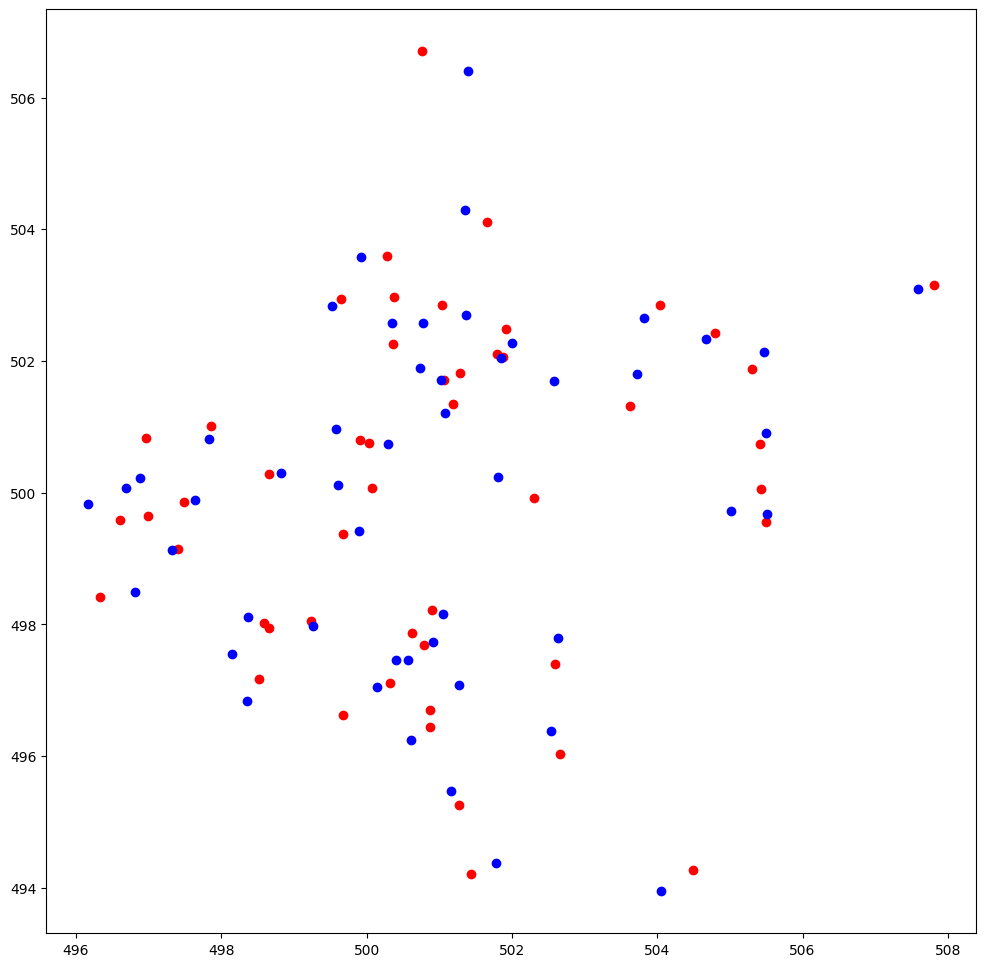

In [173]:
plt.scatter(uvs[:,0],uvs[:,1],c="r")
plt.scatter(uvs_w_noise[:,0],uvs_w_noise[:,1],c="b")

In [174]:
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(wPxs, uvs, K,dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)


In [175]:
pred_wRc,_ = cv2.Rodrigues(rotation_vector)
pred_wtc = -pred_wRc.dot(translation_vector).T[0]

In [176]:
print(pred_wRc)

[[ 4.99314767e-01  8.64838546e-01 -5.23359562e-02]
 [ 8.66025404e-01 -5.00000000e-01 -9.70277531e-16]
 [-2.61679781e-02 -4.53242676e-02 -9.98629535e-01]]


In [177]:
out_pcl_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_test2.ply"
out_camera_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/camera2.ply"

In [178]:
save_3dpoints_ply(wPxs,out_pcl_file_name,[255,0,0],True)

Ps = np.array([wtc[0],pred_wtc])
Rs = np.array([wRc,pred_wRc])
generate_multiple_camera_ply(Ps,Rs,out_camera_file_name)

In [179]:
pred_wtc

array([ 0.05226423, -0.09064854,  1.99726095])

In [180]:
wtc[0]

array([0, 0, 2])

In [181]:
-Rs[1].dot(translation_vector)

array([[ 0.05226423],
       [-0.09064854],
       [ 1.99726095]])

In [182]:
translation_vector

array([[ 1.04671912e-01],
       [-5.18438129e-16],
       [ 1.99725907e+00]])

In [183]:
Rs

array([[[ 4.99314767e-01,  8.66025404e-01, -2.61679781e-02],
        [ 8.64838546e-01, -5.00000000e-01, -4.53242676e-02],
        [-5.23359562e-02,  1.22296846e-16, -9.98629535e-01]],

       [[ 4.99314767e-01,  8.64838546e-01, -5.23359562e-02],
        [ 8.66025404e-01, -5.00000000e-01, -9.70277531e-16],
        [-2.61679781e-02, -4.53242676e-02, -9.98629535e-01]]])

In [184]:
Rs[1]

array([[ 4.99314767e-01,  8.64838546e-01, -5.23359562e-02],
       [ 8.66025404e-01, -5.00000000e-01, -9.70277531e-16],
       [-2.61679781e-02, -4.53242676e-02, -9.98629535e-01]])